<a href="https://colab.research.google.com/github/helenatong/oc_p3_cleaning_dataset_and_analysis/blob/main/project3_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Introduction**

---

## **Prerequisites**
- Download [this zip file](https://drive.google.com/file/d/1xOFMkJsbYqlR5MnkCxrgCyUOnl9zoIya/view?usp=drive_link) in Google Drive
- Modify files' path (zip_path et extract_path) within the code, 1 file in the zip


 ---

## **Context and description**

Public Health Agency France provides in opensource the database "fr.openfoodfacts.org.products", which contains information about food products sold in various points of sale.

This initiative aims to inform the public about the nutritional quality of foods. Data on each product is organized around five main themes: general product information (barcode, name), tags (packaging, category, origin, label), ingredients, nutritional information per 100g (energy, protein, sugar, sucrose, lactose), and additional information.

The objective of the study is to determine whether it is feasible to predict the values of a given variable in the dataset. The method I followed involves selecting the target variable to predict, then choosing a few relevant variables for its prediction. To determine if it is feasible, I will predict the target variable, then see the score and conclude if it's a great method. Finally, this will be followed by an exploratory analysis.

I chose to study a categorical target variable, which is the group to which the products belong.

 ---

## **Summary**

### **I. Installing and setting up the work environment**

### **II. Definitions of auxiliary functions**

### **III. xxx**

### **IV. xx**

### **V. xxxx**


# **I. Installing and setting up the work environment**

---



In [ ]:
# importation
import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
import seaborn as sns
import missingno as msno

import zipfile
import os
import sys
import datetime

from sklearn.impute import KNNImputer
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
from sklearn.metrics import confusion_matrix, classification_report

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, PowerTransformer, LabelEncoder
from sklearn.ensemble import HistGradientBoostingClassifier

from sklearn.pipeline import Pipeline

In [ ]:
# informations on virtual environment
print('Version of libraries :')
print('Python        : ' + sys.version)
print('NumPy         : ' + np.version.full_version)
print('Pandas        : ' + pd.__version__)
print('Missingno     : ' + msno.__version__)
print('seaborn       : ' + sns.__version__)
print('matplotlib    : ' + mpl.__version__)

# print('Matplotlib    : ' + mpl.__version__)
# print('Seaborn       : ' + sns.__version__)

now  = datetime.datetime.now().isoformat()
print('Run date      : ' + now)

Version of libraries :
Python        : 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
NumPy         : 1.25.2
Pandas        : 2.0.3
Missingno     : 0.5.2
seaborn       : 0.13.1
matplotlib    : 3.7.1
Run date      : 2024-04-09T16:14:55.520818


In [ ]:
# configuration on data's display
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
pd.reset_option('display.max_columns')
pd.reset_option('display.max_rows')

In [ ]:
# connection to drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# unzip file

## ⚙️ if needed, modify the path
zip_path = '/content/drive/MyDrive/openclassrooms/project_list/project_3/fr.openfoodfacts.org.products.csv.zip'
extract_path = '/content/drive/MyDrive/openclassrooms/project_list/project_3/data'

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

path_country = os.path.join(extract_path, 'fr.openfoodfacts.org.products.csv')

KeyboardInterrupt: 

In [ ]:
# create dataframe for our imported file
df = pd.read_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/fr.openfoodfacts.org.products.csv', sep = '\t', low_memory = False)

In [ ]:
# check data importation
print(df.head(2))

**CONFIGURATION**

In [ ]:
TARGET = 'pnns_groups_1'
PRODUCT_NAME = 'product_name'
NUMERIC_FEATURES =  ['energy_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g']
ALL_VARIABLES = NUMERIC_FEATURES + [PRODUCT_NAME] + [TARGET]

# **II. Definitions of auxiliary functions**


In [ ]:
def correlation_graph(pca,
                      x_y,
                      features) :
    """Affiche le graphe des correlations

    Positional arguments :
    -----------------------------------
    pca : sklearn.decomposition.PCA : notre objet PCA qui a été fit
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2
    features : list ou tuple : la liste des features (ie des dimensions) à représenter
    """

    # Extrait x et y
    x,y=x_y

    # Taille de l'image (en inches)
    fig, ax = plt.subplots(figsize=(10, 9))

    # Pour chaque composante :
    for i in range(0, pca.components_.shape[1]):

        # Les flèches
        ax.arrow(0,0,
                pca.components_[x, i],
                pca.components_[y, i],
                head_width=0.07,
                head_length=0.07,
                width=0.02, )

        # Les labels
        plt.text(pca.components_[x, i] + 0.05,
                pca.components_[y, i] + 0.05,
                NUMERIC_FEATURES[i])

    # Affichage des lignes horizontales et verticales
    plt.plot([-1, 1], [0, 0], color='grey', ls='--')
    plt.plot([0, 0], [-1, 1], color='grey', ls='--')

    # Nom des axes, avec le pourcentage d'inertie expliqué
    plt.xlabel('F{} ({}%)'.format(x+1, round(100*pca.explained_variance_ratio_[x],1)))
    plt.ylabel('F{} ({}%)'.format(y+1, round(100*pca.explained_variance_ratio_[y],1)))

    # J'ai copié collé le code sans le lire
    plt.title("Cercle des corrélations (F{} et F{})".format(x+1, y+1))

    # Le cercle
    an = np.linspace(0, 2 * np.pi, 100)
    plt.plot(np.cos(an), np.sin(an))  # Add a unit circle for scale

    # Axes et display
    plt.axis('equal')
    plt.show(block=False)

In [ ]:
def display_factorial_planes(   X_projected,
                                x_y,
                                pca=None,
                                labels = None,
                                clusters=None,
                                alpha=1,
                                figsize=[10,8],
                                marker="." ):
    """
    Affiche la projection des individus

    Positional arguments :
    -------------------------------------
    X_projected : np.array, pd.DataFrame, list of list : la matrice des points projetés
    x_y : list ou tuple : le couple x,y des plans à afficher, exemple [0,1] pour F1, F2

    Optional arguments :
    -------------------------------------
    pca : sklearn.decomposition.PCA : un objet PCA qui a été fit, cela nous permettra d'afficher la variance de chaque composante, default = None
    labels : list ou tuple : les labels des individus à projeter, default = None
    clusters : list ou tuple : la liste des clusters auquel appartient chaque individu, default = None
    alpha : float in [0,1] : paramètre de transparence, 0=100% transparent, 1=0% transparent, default = 1
    figsize : list ou tuple : couple width, height qui définit la taille de la figure en inches, default = [10,8]
    marker : str : le type de marker utilisé pour représenter les individus, points croix etc etc, default = "."
    """

    # Transforme X_projected en np.array
    X_ = np.array(X_projected)

    # On définit la forme de la figure si elle n'a pas été donnée
    if not figsize:
        figsize = (7,6)

    # On gère les labels
    if  labels is None :
        labels = []
    try :
        len(labels)
    except Exception as e :
        raise e

    # On vérifie la variable axis
    if not len(x_y) ==2 :
        raise AttributeError("2 axes sont demandées")
    if max(x_y )>= X_.shape[1] :
        raise AttributeError("la variable axis n'est pas bonne")

    # on définit x et y
    x, y = x_y

    # Initialisation de la figure
    fig, ax = plt.subplots(1, 1, figsize=figsize)

    # On vérifie s'il y a des clusters ou non
    c = None if clusters is None else clusters

    # Les points
    # plt.scatter(   X_[:, x], X_[:, y], alpha=alpha,
    #                     c=c, cmap="Set1", marker=marker)
    sns.scatterplot(data=None, x=X_[:, x], y=X_[:, y], hue=c)

    # Si la variable pca a été fournie, on peut calculer le % de variance de chaque axe
    if pca :
        v1 = str(round(100*pca.explained_variance_ratio_[x]))  + " %"
        v2 = str(round(100*pca.explained_variance_ratio_[y]))  + " %"
    else :
        v1=v2= ''

    # Nom des axes, avec le pourcentage d'inertie expliqué
    ax.set_xlabel(f'F{x+1} {v1}')
    ax.set_ylabel(f'F{y+1} {v2}')

    # Valeur x max et y max
    x_max = np.abs(X_[:, x]).max() *1.1
    y_max = np.abs(X_[:, y]).max() *1.1

    # On borne x et y
    ax.set_xlim(left=-x_max, right=x_max)
    ax.set_ylim(bottom= -y_max, top=y_max)

    # Affichage des lignes horizontales et verticales
    plt.plot([-x_max, x_max], [0, 0], color='grey', alpha=0.8)
    plt.plot([0,0], [-y_max, y_max], color='grey', alpha=0.8)

    # Affichage des labels des points
    if len(labels) :
        # j'ai copié collé la fonction sans la lire
        for i,(_x,_y) in enumerate(X_[:,[x,y]]):
            plt.text(_x, _y+0.05, labels[i], fontsize='12', ha='center',va='center')

    # Titre et display
    plt.title(f"Projection des individus (sur F{x+1} et F{y+1})")
    plt.show()

# **III. Exploratory phase**
---
  
- choose the target variable (1)
- select all relevant variables for target variable analysis (9)
- remove duplicates and unnecessary informations

## A. Cleaning and choice of the target variable

To choose the target variable, I first cleaned up by deleting empty columns and rows to simplify the database.
I then chose a categorical variable with a missing value greater than 50% (customer requirement). This first step is a technical constraint, then I'll use the business constraint to choose the most relevant variable to analyze.

**Cleaning**

In [ ]:
# dataframe dimension
nb_row, nb_column = df.shape

print(f'number of rows : {nb_row} \nnumber of columns : {nb_column}')

In [ ]:
# remove empty column
is_empty_column = df.isna().sum(axis = 0) == nb_row
empty_column = df.columns[is_empty_column]
print(f'{is_empty_column.sum()} columns dropped. \nList of dropped columns :\n {empty_column}')
df.drop(empty_column, axis = 1, inplace = True)

In [ ]:
# remove empty rows
is_empty_row = df.isna().sum(axis = 1) == nb_column
empty_row = df.index[is_empty_row]
print(f'There is {is_empty_row.sum(axis = 0)} empty rows')

In [ ]:
# missing value
nb_row, nb_column = df.shape
missing_counts = df.isna().sum()
missing_percentage = (missing_counts / nb_row) * 100

missing_summary = pd.DataFrame({
    'mv(nb)': missing_counts,
    'mv(%)': missing_percentage.apply(lambda x: f'{x:.2f}%')
})

pd.set_option('display.max_rows', None)
print(f'Missing value :')
print(missing_summary.sort_values('mv(nb)'))
pd.reset_option('display.max_rows')

**Choose the target variable**

From a technical point of view, according to this list, the categorical variables that have between 50% and 80% missing values are the following: additives_tags, additives_fr, pnns_groups_2, pnns_groups_1, categories_fr, categories, categories_tags, main_category_fr, main_category, packaging_tags, packaging.

From a business point of view, it's interesting to be able to predict values of the group of food a product belongs to.

Let's now look at the content of the following variables.

In [ ]:
main_variable_selection = ['pnns_groups_2', 'pnns_groups_1', 'categories', 'categories_tags', 'main_category']

for var in main_variable_selection:
    print('examples of values in', var , ':\n', df[var].unique()[:5], end = '\n---\n')

In [ ]:
# display all element in each pnns_groups variable
print('all values in pnns_groups_1 :\n', df['pnns_groups_1'].unique(), end = '\n---\n')
print('all values in pnns_groups_2 :\n', df['pnns_groups_2'].unique())

Category variable are not homogenous in one language, I'm choosing pnns_groups_1 which is more concise as pnns_groups_2.

In [ ]:
# harmonize value for the target variable
mapping = {
    'fruits-and-vegetables' : 'Fruits and vegetables',
    'sugary-snacks'   : 'Sugary snacks',
    'salty-snacks'   : 'Salty snacks',
    'cereals-and-potatoes' : 'Cereals and potatoes',
    ''   : '',
}

df[TARGET] = df[TARGET].replace(mapping)

print('updated values in {TARGET} :\n', df[TARGET].unique())

## B. Choose revelant variable to analyze the target variable

To choose feature variable for the target variable, I prioritize variable with > 50% of available value.

In [ ]:
# checing the % of available value
nb_row, nb_column = df.shape
missing_counts = df.isna().sum()
missing_percentage = (missing_counts / nb_row) * 100

missing_summary = pd.DataFrame({
    'mv(nb)': missing_counts,
    'mv(%)': missing_percentage.apply(lambda x: f'{x:.2f}%')
})

pd.set_option('display.max_rows', None)
print(f'Missing value :')
print(missing_summary.sort_values('mv(nb)'))
pd.reset_option('display.max_rows')

Among the variables the following one are the one chosen for the analyze :
- product_name : to identify the product
- energy_100g : related to the product's nutritional value
- proteins_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, sodium_100g*, fiber_100g related to the the product composition.

*I chose sodium_100g over salt_100g which is an arbitrary choice. (1g of sodium = 2,5g of salt)*


In [ ]:
# drop unused variables

col_to_drop = df.columns.difference(ALL_VARIABLES)
df.drop(columns = col_to_drop, inplace = True)

In [ ]:
df

## C. Cleaning the dataset with selected variables

Remove empty rows, duplicates and non informative rows

In [ ]:
# remove rows without product name
removed_rows = df[PRODUCT_NAME].isna().sum()
print(f'{removed_rows} rows without product name have been removed')

df.dropna(subset=[PRODUCT_NAME], inplace=True)

In [ ]:
# remove empty rows, an empty row is NaN value for quantitative variables (does not include product_name and pnns_groups_2)
is_empty_row = df[NUMERIC_FEATURES].isna().sum(axis = 1) >= len(NUMERIC_FEATURES) - 1
empty_row = df.index[is_empty_row]
print(f'{is_empty_row.sum(axis = 0)} empty rows have been removed')

df.drop(empty_row, axis = 0, inplace = True)

In [ ]:
# remove duplicates, a duplicate is 2 rows with the same product_name
nb_duplicate = df.duplicated(subset = PRODUCT_NAME).sum()
print(f'{nb_duplicate} duplicated rows have been removed')

df.drop_duplicates(subset = PRODUCT_NAME, inplace = True)
print(f'remaining rows : {df.shape[0]}')

In [ ]:
# matrix to see missing values
f, axes = plt.subplots(1,2, figsize=(30, 10))

msno.bar(df,
         color="dodgerblue",
         sort="descending",
         ax = axes[0]
        ).set_title("Graph of missing values \n", fontsize = 30)

msno.matrix(df,
            color=(0.27, 0.52, 1.0),
            sort="descending",
            sparkline = False,
            ax = axes[1]
           ).set_title("Matrix of missing values \n", fontsize = 30)

# **IV. Delete impossible values deletion**
---

The quantity for the nutrient variable (proteins_100g, fat_100g, saturated-fat_100g, carbohydrates_100g, sugars_100g, sodium_100g, fiber_100g) can not exceed 100g.

At maximum, a product can contains 900 kcal or 3766 kJ which is a product with fat_100g = 100g. Indeed 1g of protein contains 4 calories, 1g of carbohydrates contains 4 calories, 1g of fat contains 9 calories, 1g of fiber contains 2 calories.

Therefore, I removed those impossible values.

In [ ]:
# remove impossible value
mask = ((df['proteins_100g'] > 100) | (df['fat_100g'] > 100) | (df['saturated-fat_100g'] > 100) | (df['carbohydrates_100g'] > 100) | (df['sugars_100g'] > 100) | (df['sodium_100g'] > 100) | (df['fiber_100g'] > 100) | (df['energy_100g'] > 3766))
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

The sum of the quantity for the nutrient variables proteins_100g, fat_100g, carbohydrates_100g, sodium_100g, fiber_100g can not exceed 100g

In [ ]:
# remove impossible value
mask = (df['proteins_100g'] + df['fat_100g'] + df['carbohydrates_100g'] + df['sodium_100g'] + df['fiber_100g'] > 100)
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

Quantitative variables can not be negative

In [ ]:
# remove impossible value
mask = ((df['proteins_100g'] < 0) | (df['fat_100g'] < 0) | (df['saturated-fat_100g'] < 0) | (df['carbohydrates_100g'] < 0) | (df['sugars_100g'] < 0) | (df['sodium_100g'] < 0) | (df['fiber_100g'] < 0) | (df['energy_100g'] < 0))
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

According to business rule : fat_100g > saturated-fat_100g and carbohydrates_100g > sugars_100g

In [ ]:
# remove impossible value
mask = ((df['fat_100g'] < df['saturated-fat_100g']) | (df['carbohydrates_100g'] < df['sugars_100g']))
rows_before = df.shape[0]
df.drop(df[mask].index, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

# **V. Data pre-processing by imputation : Replace NaN values**

To replace missing values, here is the logic :
- Understanding the characteristics of a variable

  Missing value for fiber means that the product doesn't contain any

- See if there are correlations between certain variables to use linear regression imputation.
- As for the order on which variable to imput first, I will start with the most accurate estimates (correlated variable, fiber = 0) before imputing with less precise method like statistical ones

## **A. Impute values**


In [ ]:
df_before_imputation = df.copy()

In [ ]:
# missing value
nb_row, nb_column = df.shape
missing_counts = df.isna().sum()
missing_percentage = (missing_counts / nb_row) * 100

missing_summary = pd.DataFrame({
    'mv(nb)': missing_counts,
    'mv(%)': missing_percentage.apply(lambda x: f'{x:.2f}%')
})

print(f'Missing value :')
print(missing_summary.sort_values('mv(nb)'))

When the value of fiber_100g is missing, the product contains none

In [ ]:
df['fiber_100g'] = df['fiber_100g'].fillna(0)

Let's see correlation matrix to identify methods which can be use to impute values


In [ ]:
# correlation
correlation_matrix = df[NUMERIC_FEATURES].corr()

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix for quantitative variables')
plt.show()

The couple fat/saturated fat and sugars/carbohydrates have a correlation of 0.75 and 0.69 respectively.

Let's plot a graph to check the linearity of the values.


In [ ]:
# extract a sample to have a proper view
df_sample = df.sample(3000)

fat = df_sample['fat_100g']
sfat = df_sample['saturated-fat_100g']
carbohydrate = df_sample['carbohydrates_100g']
sugar = df_sample['sugars_100g']
energy = df_sample['sugars_100g']

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(12, 6))

# first graph
ax1.scatter(fat, sfat, alpha=0.5, color='blue')
ax1.set_title('scatter plot fat/saturated-fat')
ax1.set_xlabel('fat')
ax1.set_ylabel('saturated-fat')
ax1.grid(True)

# second graph
ax2.scatter(carbohydrate, sugar, alpha=0.5, color='red')
ax2.set_title('scatter plot carbohydrate/sugar')
ax2.set_xlabel('carbohydrates')
ax2.set_ylabel('sugars')
ax2.grid(True)

# second graph
ax3.scatter(fat, energy, alpha=0.5, color='green')
ax3.set_title('scatter plot fat/energy')
ax3.set_xlabel('fat')
ax3.set_ylabel('energy')
ax3.grid(True)

plt.tight_layout()
plt.show()

The linearity is not obvious, I will use KKNImputer method to imput values for sodium, proteins, fat, saturated-fat, sugars, carbohydrates.

In [ ]:
impute_knn = KNNImputer(n_neighbors=3)
columns_to_impute = ['sodium_100g', 'proteins_100g', 'fat_100g', 'saturated-fat_100g', 'sugars_100g', 'carbohydrates_100g']
df[columns_to_impute] = impute_knn.fit_transform(df[columns_to_impute]) #12min

Since 1g of protein contains 4 calories, 1g of carbohydrates contains 4 calories, 1g of fat contains 9 calories, 1g of fiber contains 2 calories, I can deduct the energy value

In [ ]:
df.loc[df['energy_100g'].isna(), 'energy_100g'] = 4 * df['proteins_100g'] + 4 * df['carbohydrates_100g'] + 9 * df['fat_100g'] + 2 * df['fiber_100g']

## **B. Compare distribution before and after imputation**

In [ ]:
# distribution before imputation
df_before_imputation[NUMERIC_FEATURES].hist(bins=50)
plt.tight_layout()

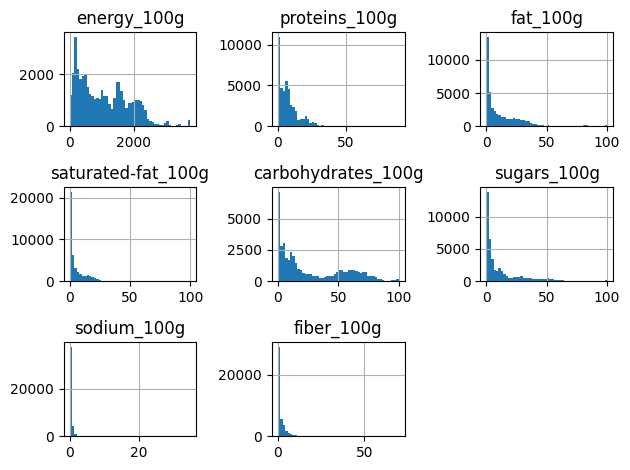

In [ ]:
# distribution after imputation
df[NUMERIC_FEATURES].hist(bins=50)
plt.tight_layout()

Globally, distribution has been preserved.


Small differences are visible for the energy variable, where a peak can be observed around 2000 kJ, and for the sodium variable, where a second peak appears.

# **VI. Predict and Access the quality of prediction**


Delete NaN value for target variable to train and test models

In [ ]:
# df.to_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/df_cleaned.csv', index=False)

In [ ]:
# create dataframe for our imported file
df = pd.read_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/df_cleaned.csv', sep = ',', low_memory = False)

In [ ]:
# remove NaN value for TARGET
rows_before = df.shape[0]
df.dropna(subset = TARGET, inplace=True)

rows_now = df.shape[0]
rows_removed = rows_before - rows_now
print(f'Number of rows removed: {rows_removed}\n{rows_now} remaining')

In [ ]:
# remove unknown value for TARGET
nb_rows_to_remove = df.loc[df[TARGET] == 'unknown', TARGET].count()
df = df[df[TARGET] != 'unknown']
rows_now = df.loc[df[TARGET] != 'unknown', TARGET].count()

rows_removed = rows_before - rows_now
print(f'Number of rows removed: {nb_rows_to_remove}\n{rows_now} remaining')

In [ ]:
print(df.shape)
df

In [ ]:
df[TARGET].value_counts(normalize=True)

In [ ]:
# transform the class form text to integer
encoder =  LabelEncoder()
y_encoded = encoder.fit_transform(df[TARGET].values)

# create dataset for training and testing
X = df[NUMERIC_FEATURES].values
X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.20, random_state=42)

The target variable is multi-class and categorical. I therefore chose a Gradient Boosting algorithm.

HistGradientBoostingClassifier is faster to train than GradientBoostingClassifier for samples greater than 10000.

In [ ]:
#create pipeline to normalize values and fit model
my_pipeline = Pipeline([
    ('power_transform', PowerTransformer()),
    ('classifier', HistGradientBoostingClassifier())
])

In [ ]:
# check standardization by power_transform
my_pipeline.fit(X_train, y_train_encoded)
X_train_transformed = my_pipeline.named_steps['power_transform'].transform(X_train)
df_transformed = pd.DataFrame(X_train_transformed, columns=NUMERIC_FEATURES)
print(df_transformed.describe().apply(lambda s: s.apply('{0:.2f}'.format)))
print('----------------')

# fit model by using grid search
param_grid = {
    'classifier__max_iter'          : [1000],
    'classifier__max_depth'         : [8, 9, 10],
    'classifier__learning_rate'     : [0.06, 0.07, 0.08],
    'classifier__random_state'      : [42]
}
grid_search = GridSearchCV(my_pipeline, param_grid, cv=5, verbose=1, n_jobs=-1, refit=True)
grid_search.fit(X_train, y_train_encoded)
print(grid_search.best_params_)
print('----------------')

# model scoring
best_model = grid_search.best_estimator_
print(f'Model\'s score : {best_model.score(X_train, y_train_encoded).round(3)}')
print(f'Model\'s score on test dataset : {best_model.score(X_test, y_test_encoded).round(3)}')

# {'learning_rate': 0.07, 'max_depth': 9, 'max_iter': 1000, 'random_state': 42}
# Model's score : 0.96
# Model's score on test dataset : 0.881

The best model obtained is overfitted on training dataset.

In [ ]:
# check prediction's details
y_pred_encoded = best_model.predict(X_test)
y_pred = encoder.inverse_transform(y_pred_encoded)
y_test = encoder.inverse_transform(y_test_encoded)
print(classification_report(y_test, y_pred))

Out of 8694 products, 7650 categories were accurately predicted.

The model correctly predicted 90% of the following categories: Beverages, Fish Meat Eggs, Milk and diary products and Sugary snacks.

It performed less well in predicting the Fruit and vegetables category (22% incorrect prediction).

In [ ]:
sns.heatmap(confusion_matrix(y_true = y_test,y_pred = y_pred) , cmap="YlGnBu")

Let's see if we can improve our model by increasing the amount of data provided using the learning curve method.

In [ ]:
# N, train_score, val_score = learning_curve(best_model, X_train, y_train_encoded,
#                                            train_sizes = np.linspace(0.1, 1.0, 5), cv=5)
# plt.plot(N, train_score.mean(axis=1), label='train')
# plt.plot(N, val_score.mean(axis=1), label='validation')
# plt.xlabel('train_size')
# plt.legend()

A plateau seems to be reached at 9000, so more data won't produce better forecasts.

**Conclusion on the on the feasibility of predicting the target variable**

The main objective is to determine if it is feasible to find a prediction method to fill in the missing data of the target variable pnns_groups_1.

The training dataset achieves a score of 96%, while the test dataset achieves a score of 88%, indicating overfitting.

However, this result is encouraging and represents a good score. Furthermore, it is possible to improve it through various means such as variable selection, imputation method, and model parameter tuning.

# **VII. Data analysis**

## **A. Univariate an Bivariate analysis**

**UNIVARIATE ANALYSIS**

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/openclassrooms/project_list/project_3/data/df_cleaned.csv', sep = ',', low_memory = False)

In [ ]:
# statistic information
df.describe().apply(lambda s: s.apply('{0:.0f}'.format))

,energy_100g,fat_100g,saturated-fat_100g,carbohydrates_100g,sugars_100g,fiber_100g,proteins_100g,sodium_100g
count,43468,43468,43468,43468,43468,43468,43468,43468
mean,1079,13,5,28,13,2,7,0
std,780,16,8,27,18,3,7,1
min,0,0,0,0,0,0,0,0
25%,382,1,0,4,1,0,2,0
50%,975,6,2,15,5,0,6,0
75%,1640,21,8,52,18,2,10,0
max,3766,100,100,100,100,70,88,35


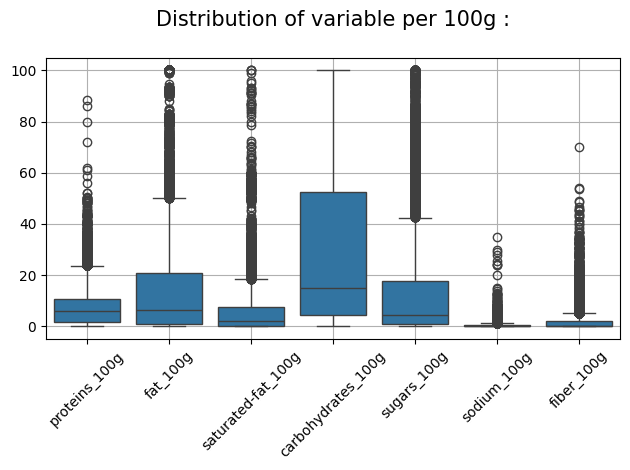

In [ ]:
# plot all boxbot to have a general view
comp_feature_variable = ['proteins_100g', 'fat_100g', 'saturated-fat_100g', 'carbohydrates_100g', 'sugars_100g', 'sodium_100g', 'fiber_100g']
df_melted = pd.melt(df, id_vars = [PRODUCT_NAME, TARGET], value_vars = comp_feature_variable , var_name='variable', value_name='value')

ax = sns.boxplot(x = 'variable', y = 'value', data = df_melted.loc[df_melted['variable'].isin(comp_feature_variable), :])
ax.set_title('Distribution of variable per 100g :\n', fontsize=15)
ax.set_xlabel('')
ax.set_ylabel('', fontsize=10)
ax.tick_params(axis='x', labelsize=10, rotation = 45)
ax.tick_params(axis='y', labelsize=10)
ax.grid(True)

plt.tight_layout()
plt.show()

<ipython-input-51-869188c7cdc1>:13: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(category_counts.index, rotation=45, ha='right')


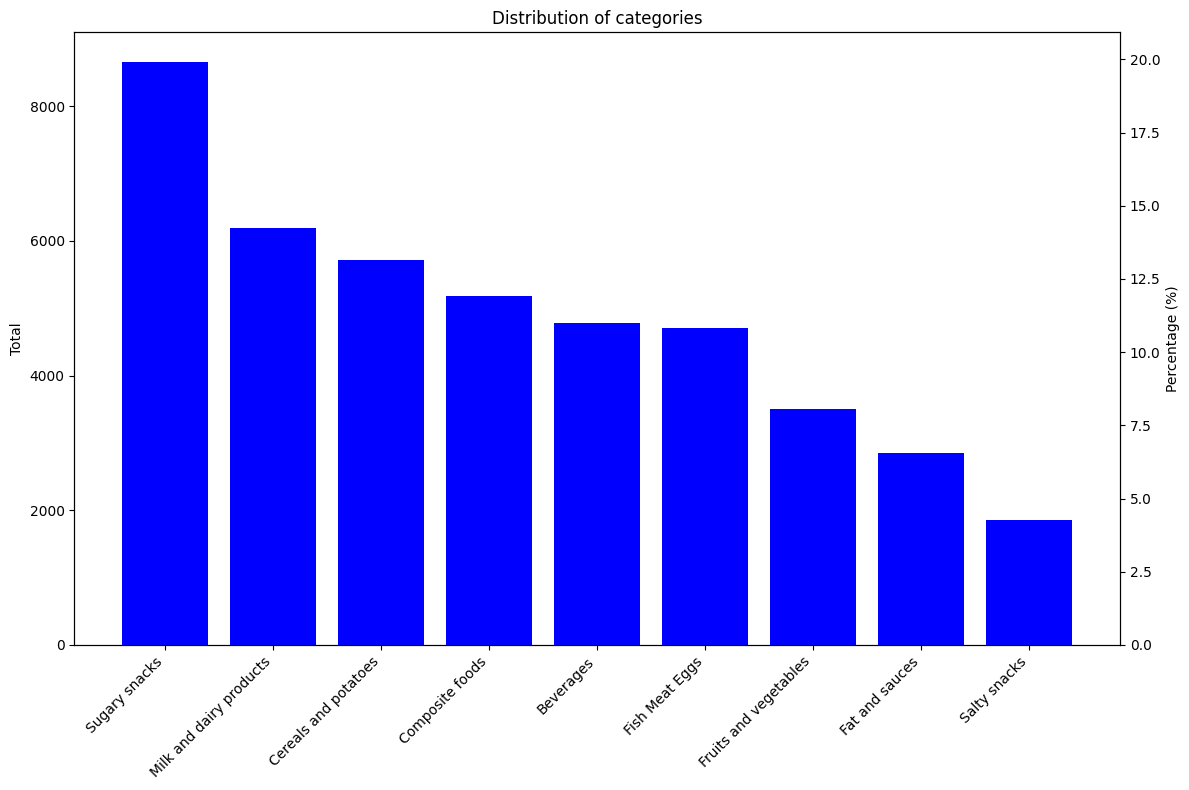

pnns_groups_1
Sugary snacks              19.929603
Milk and dairy products    14.228858
Cereals and potatoes       13.159106
Composite foods            11.930616
Beverages                  11.001196
Fish Meat Eggs             10.830956
Fruits and vegetables       8.070305
Fat and sauces              6.570351
Salty snacks                4.279010
Name: count, dtype: float64


In [ ]:
# category distribution
category_counts = df[TARGET].value_counts()

category_percentages = (category_counts / len(df)) * 100
fig, ax1 = plt.subplots(figsize=(12, 8))
ax1.bar(category_counts.index, category_counts.values, color='b')

ax2 = ax1.twinx()
ax2.bar(category_counts.index,category_percentages.values, color='b')

ax2.set_ylabel('Percentage (%)')
ax1.set_ylabel('Total')
ax1.set_xticklabels(category_counts.index, rotation=45, ha='right')

plt.title('Distribution of categories')
plt.tight_layout()
plt.show()

print(category_percentages)

**BIVARIATE ANALYSIS**

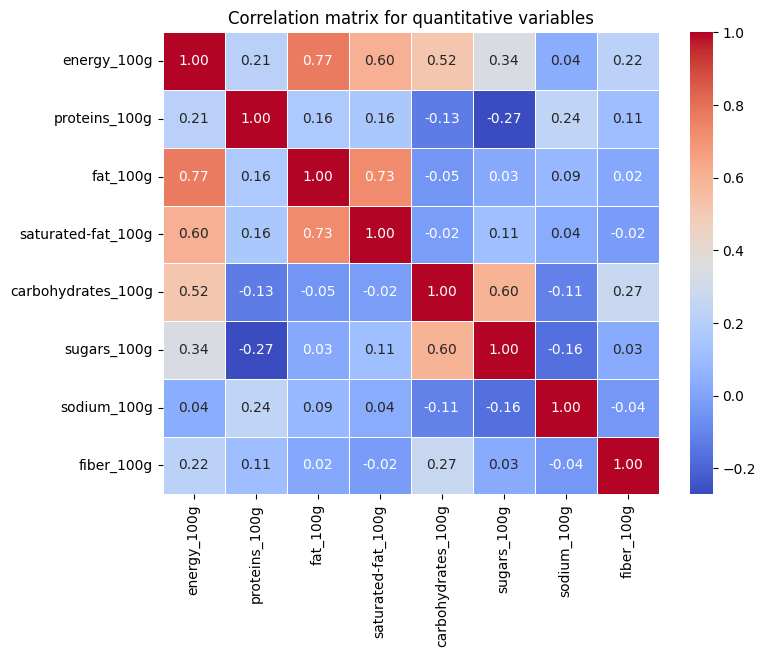

In [ ]:
# correlation
correlation_matrix = df[NUMERIC_FEATURES].corr()

# plot
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title('Correlation matrix for quantitative variables')
plt.show()

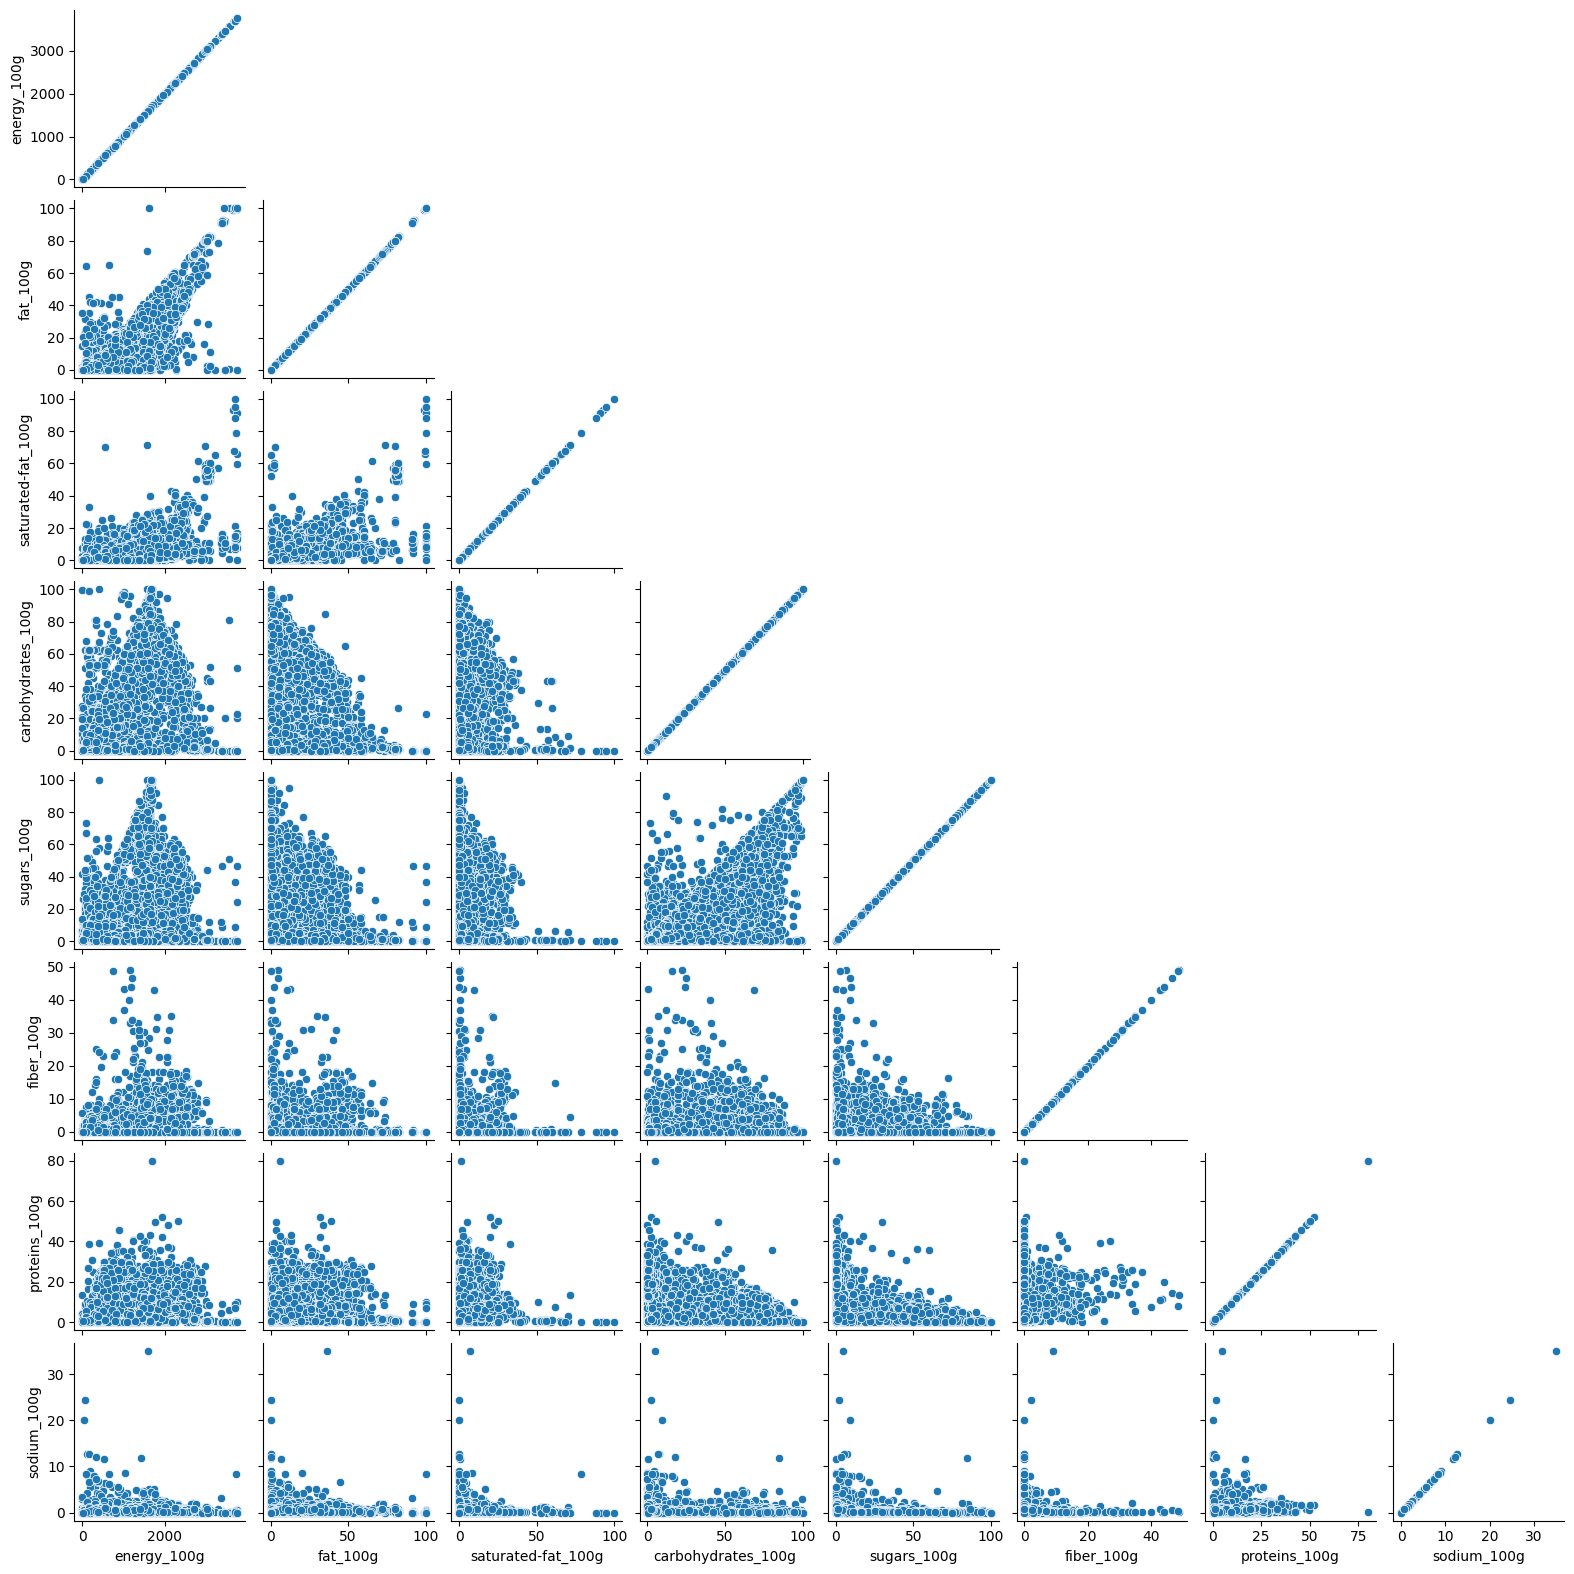

In [ ]:
# display variables pairing
sns.pairplot(df.sample(10000), height=2, diag_kind= None, corner=True)
plt.show()

There is a significant correlation between the variables fat/energy (77%) and fat/saturated_fat (73%).

This observation is consistent with the fact that energy content is largely influenced by the presence of fat.

Also, given that saturated_fat is included in fats, it's not surprising to see this high correlation between the two.

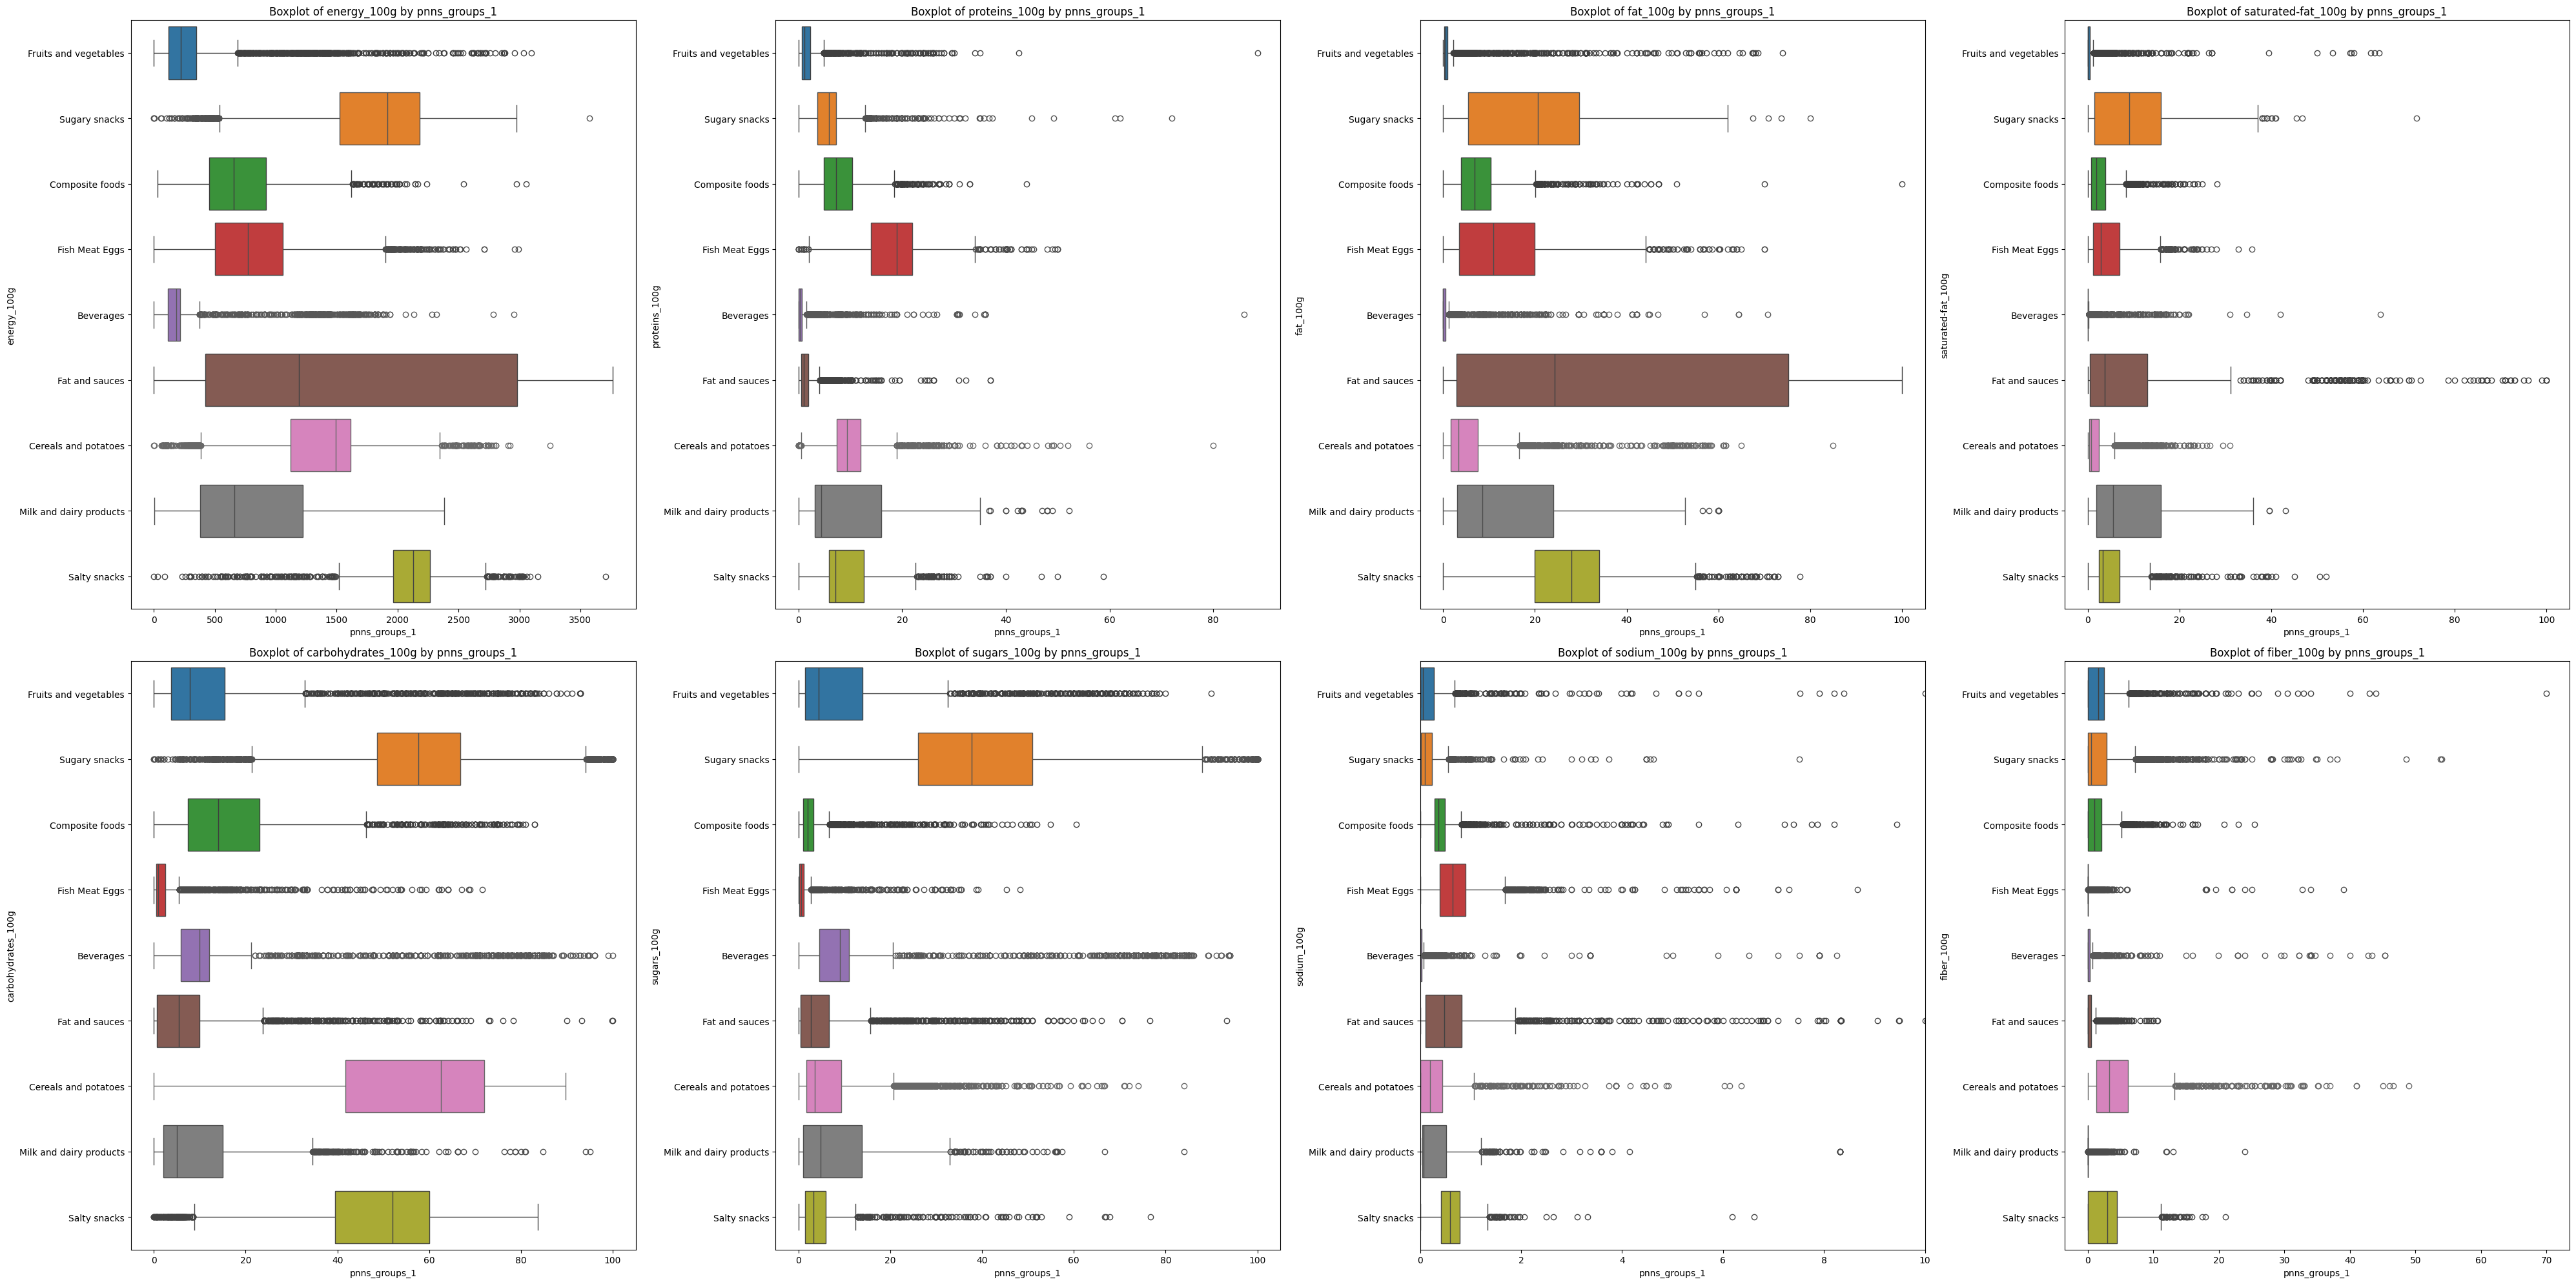

In [ ]:
# plot target variable with quantitative variables
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(40, 20))
axes = axes.flatten()
for i, var in enumerate(NUMERIC_FEATURES):
    for target_category in df[TARGET].unique():
        sns.boxplot(y=TARGET, x=var, data=df[df[TARGET] == target_category], ax=axes[i])
        axes[i].set_title(f'Boxplot of {var} by {TARGET}')
        axes[i].set_xlabel(TARGET)
        axes[i].set_ylabel(var)
        if i == 6:
          axes[i].set_xlim(0, 10)
plt.tight_layout()
plt.show()

Unsurprisingly, the foods richest in protein are found in the Fish Meat Egg group, while the foods richest in sugar are found in the Sugary Snack group.

In terms of carbohydrates, the Cereals and Potatoes group come out on top, as these foods contain slow sugars, along with the Sugary Snack group, which contains fast sugars. In contrast, the Fish Meat Egg modality is low in carbohydrates.

As for fat and saturated fat, the Fruits and Vegetables group contains very little, compared with the Sugary Snack and Fat and Sauces groups.

For the Salty snack group, we can see that the median for the fat category is in the top 3, but this isn't the case for the saturated-fat category.
This is explained by the fact that Salty snacks are often nuts/cashew nuts etc. which are high in fat but low in saturated-fat.

Fat and sugar contribute more to a high energy value. This explains why the Fat and sauces, Sugary Snack, Cereals and potatoes, and Salty snack groups are in the lead.

It is difficult to draw conclusions on the fiber and sodium modalities, as the values are very close.

## **B. Multivariate analysis**


In [ ]:
df1 = df[NUMERIC_FEATURES]
X = df1.values

In [ ]:
# standartize with PowerTransformer and not StandardScaler because the distribution is not normal
scaler = PowerTransformer()
X_scaled = scaler.fit_transform(X)

# check if standartized
idx = ["mean", "std"]
pd.DataFrame(X_scaled).describe().round(2).loc[idx, :]

,0,1,2,3,4,5,6,7
mean,-0.0,-0.0,0.0,0.0,0.0,0.0,-0.0,-0.0
std,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0


In [ ]:
# faire l'ACP avec les données centrées-réduites
n_components = 8 #== min(n_samples, n_features)
pca = PCA(n_components=n_components) #instanciation, n_components
pca.fit(X_scaled)

PCA(n_components=8)

In [ ]:
# value of each principal component
pca.explained_variance_ratio_

array([0.38177932, 0.26889161, 0.13711582, 0.07850257, 0.05966685,
       0.04440397, 0.01843858, 0.01120127])

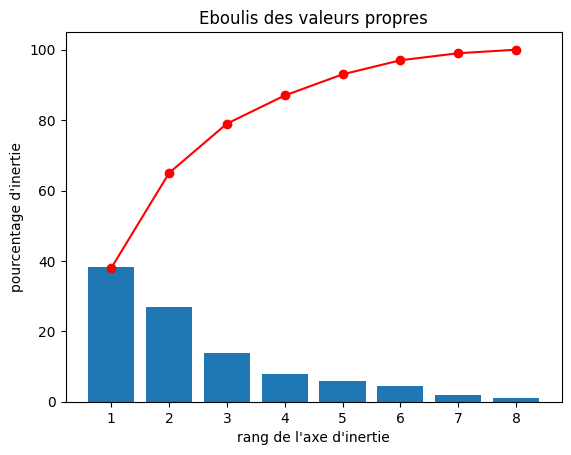

In [ ]:
scree = (pca.explained_variance_ratio_*100).round(2)
scree_cum = scree.cumsum().round()
x_list = list(range(1, n_components+1))

plt.bar(x_list, scree)
plt.plot(x_list, scree_cum,c="red",marker='o')
plt.xlabel("rang de l'axe d'inertie")
plt.ylabel("pourcentage d'inertie")
plt.title("Eboulis des valeurs propres")
plt.show(block=False)

The first plane (composed of PC1 and PC2) explains 65% of the variability in the data and the first two planes (composed of PC1, PC2, PC3, and PC4) explain 87% of the variability.

In [ ]:
#% d'inertie par axe composante principale
pcs = pca.components_
pcs = pd.DataFrame(pcs * 100).round()
pcs.columns = NUMERIC_FEATURES
pcs.index = [f"F{i}" for i in x_list]

(pcs.head(4).T)

,F1,F2,F3,F4
energy_100g,47.0,-29.0,-5.0,2.0
proteins_100g,40.0,19.0,33.0,-21.0
fat_100g,53.0,-0.0,-19.0,26.0
saturated-fat_100g,50.0,-2.0,-32.0,22.0
carbohydrates_100g,6.0,-60.0,18.0,-36.0
sugars_100g,-4.0,-57.0,-25.0,-31.0
sodium_100g,30.0,33.0,30.0,-62.0
fiber_100g,5.0,-29.0,75.0,48.0


The most contributing variables to F1 are: fat_100g (53), saturated-fat_100g (50), energy_100g (47).
These variables are positive, suggesting a positive correlation with the F1 axis. In other words, products with high values for these variables are generally located on the positive side of F1.

The most contributing variables to F2 are: carbohydrates_100g (-60), sugars_100g (-57), sodium_100g (33).
The variable carbohydrates_100g and sugars_100g are highly negative, indicating a strong negative correlation with the F2 axis. This means that products with high values of carbohydrates_100g and sugars_100g tend to be located on the negative side of F2.

The most contributing variable to F3 is fiber_100g (75), followed by proteins_100g (33) and sodium_100g (30) as positive influence and saturated-fat_100g (-32) and sugars (-25) as negative influence.

The most contributing variable to F4 is sodium (-62) followed by fiber (48). In addition, the variables carbohydrates and sugar (-67) contribute almost as much as sodium.

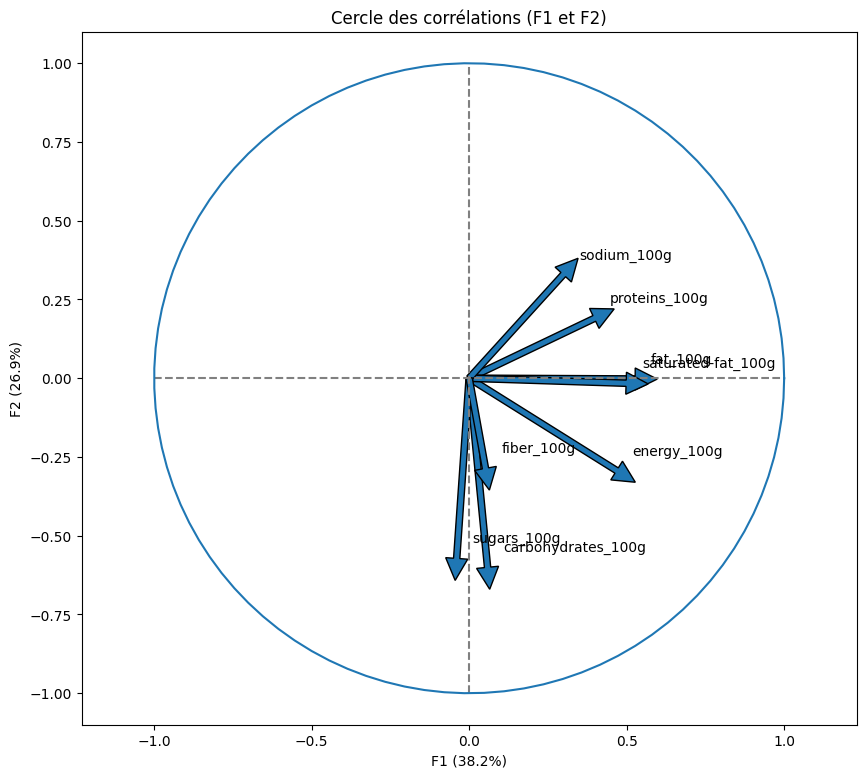

In [ ]:
# first plane
correlation_graph(pca, (0,1), NUMERIC_FEATURES)

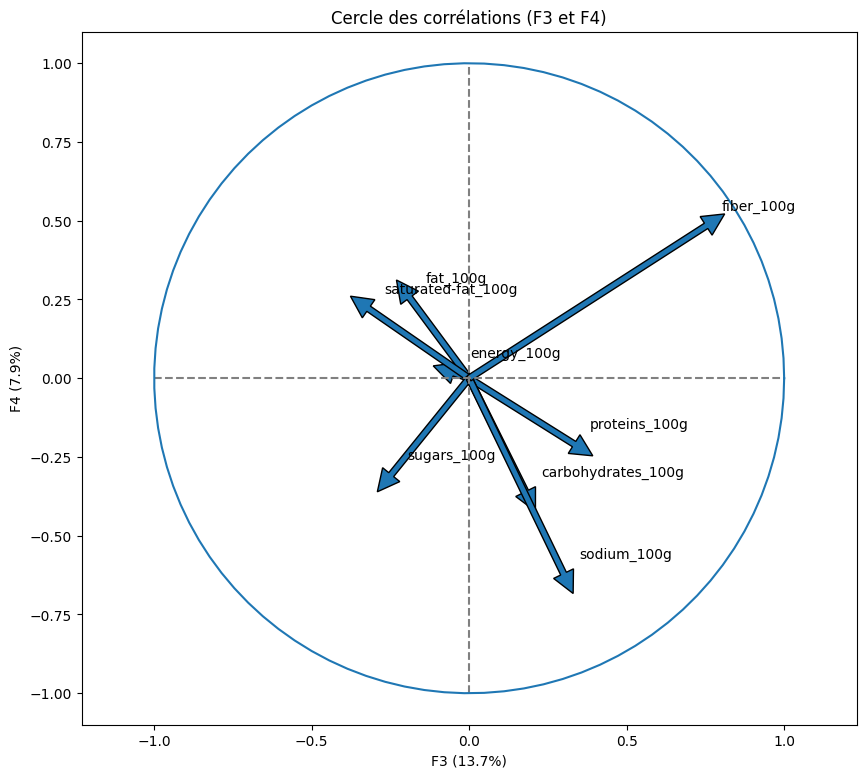

In [ ]:
# second plane
correlation_graph(pca, (2,3), NUMERIC_FEATURES)

## Individus

In [ ]:
X_proj = pca.transform(X_scaled)
X_proj[:5]

array([[ 2.06097586,  1.11634011,  1.78598988, -0.01613144,  0.14120887,
         0.27916277, -0.776426  ,  0.14192163],
       [ 1.49112998, -1.62442504,  0.2748219 , -0.11261178, -0.89347338,
        -0.50753172, -0.43102872,  0.21688677],
       [ 0.29403532, -1.40400115,  0.48250366, -0.03313748, -0.77399796,
        -0.34847029,  0.16992675, -0.26677684],
       [-0.11717577,  1.13084824,  0.02214119,  0.53416977,  0.04660113,
         0.15510606, -0.53199196, -0.15475322],
       [ 0.53961636,  0.31532825,  0.16528632, -1.47338288,  1.46303441,
        -1.05556669,  0.84193224, -0.93421421]])

In [ ]:
from sklearn.cluster import KMeans
# retrieve centers of gravity for each modality
X = X_proj
n_clusters = df[TARGET].nunique()
kmeans = KMeans(n_clusters=n_clusters)
kmeans.fit(X)
cluster_centers = kmeans.cluster_centers_
# print("Centres des clusters :")
# print(cluster_centers)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


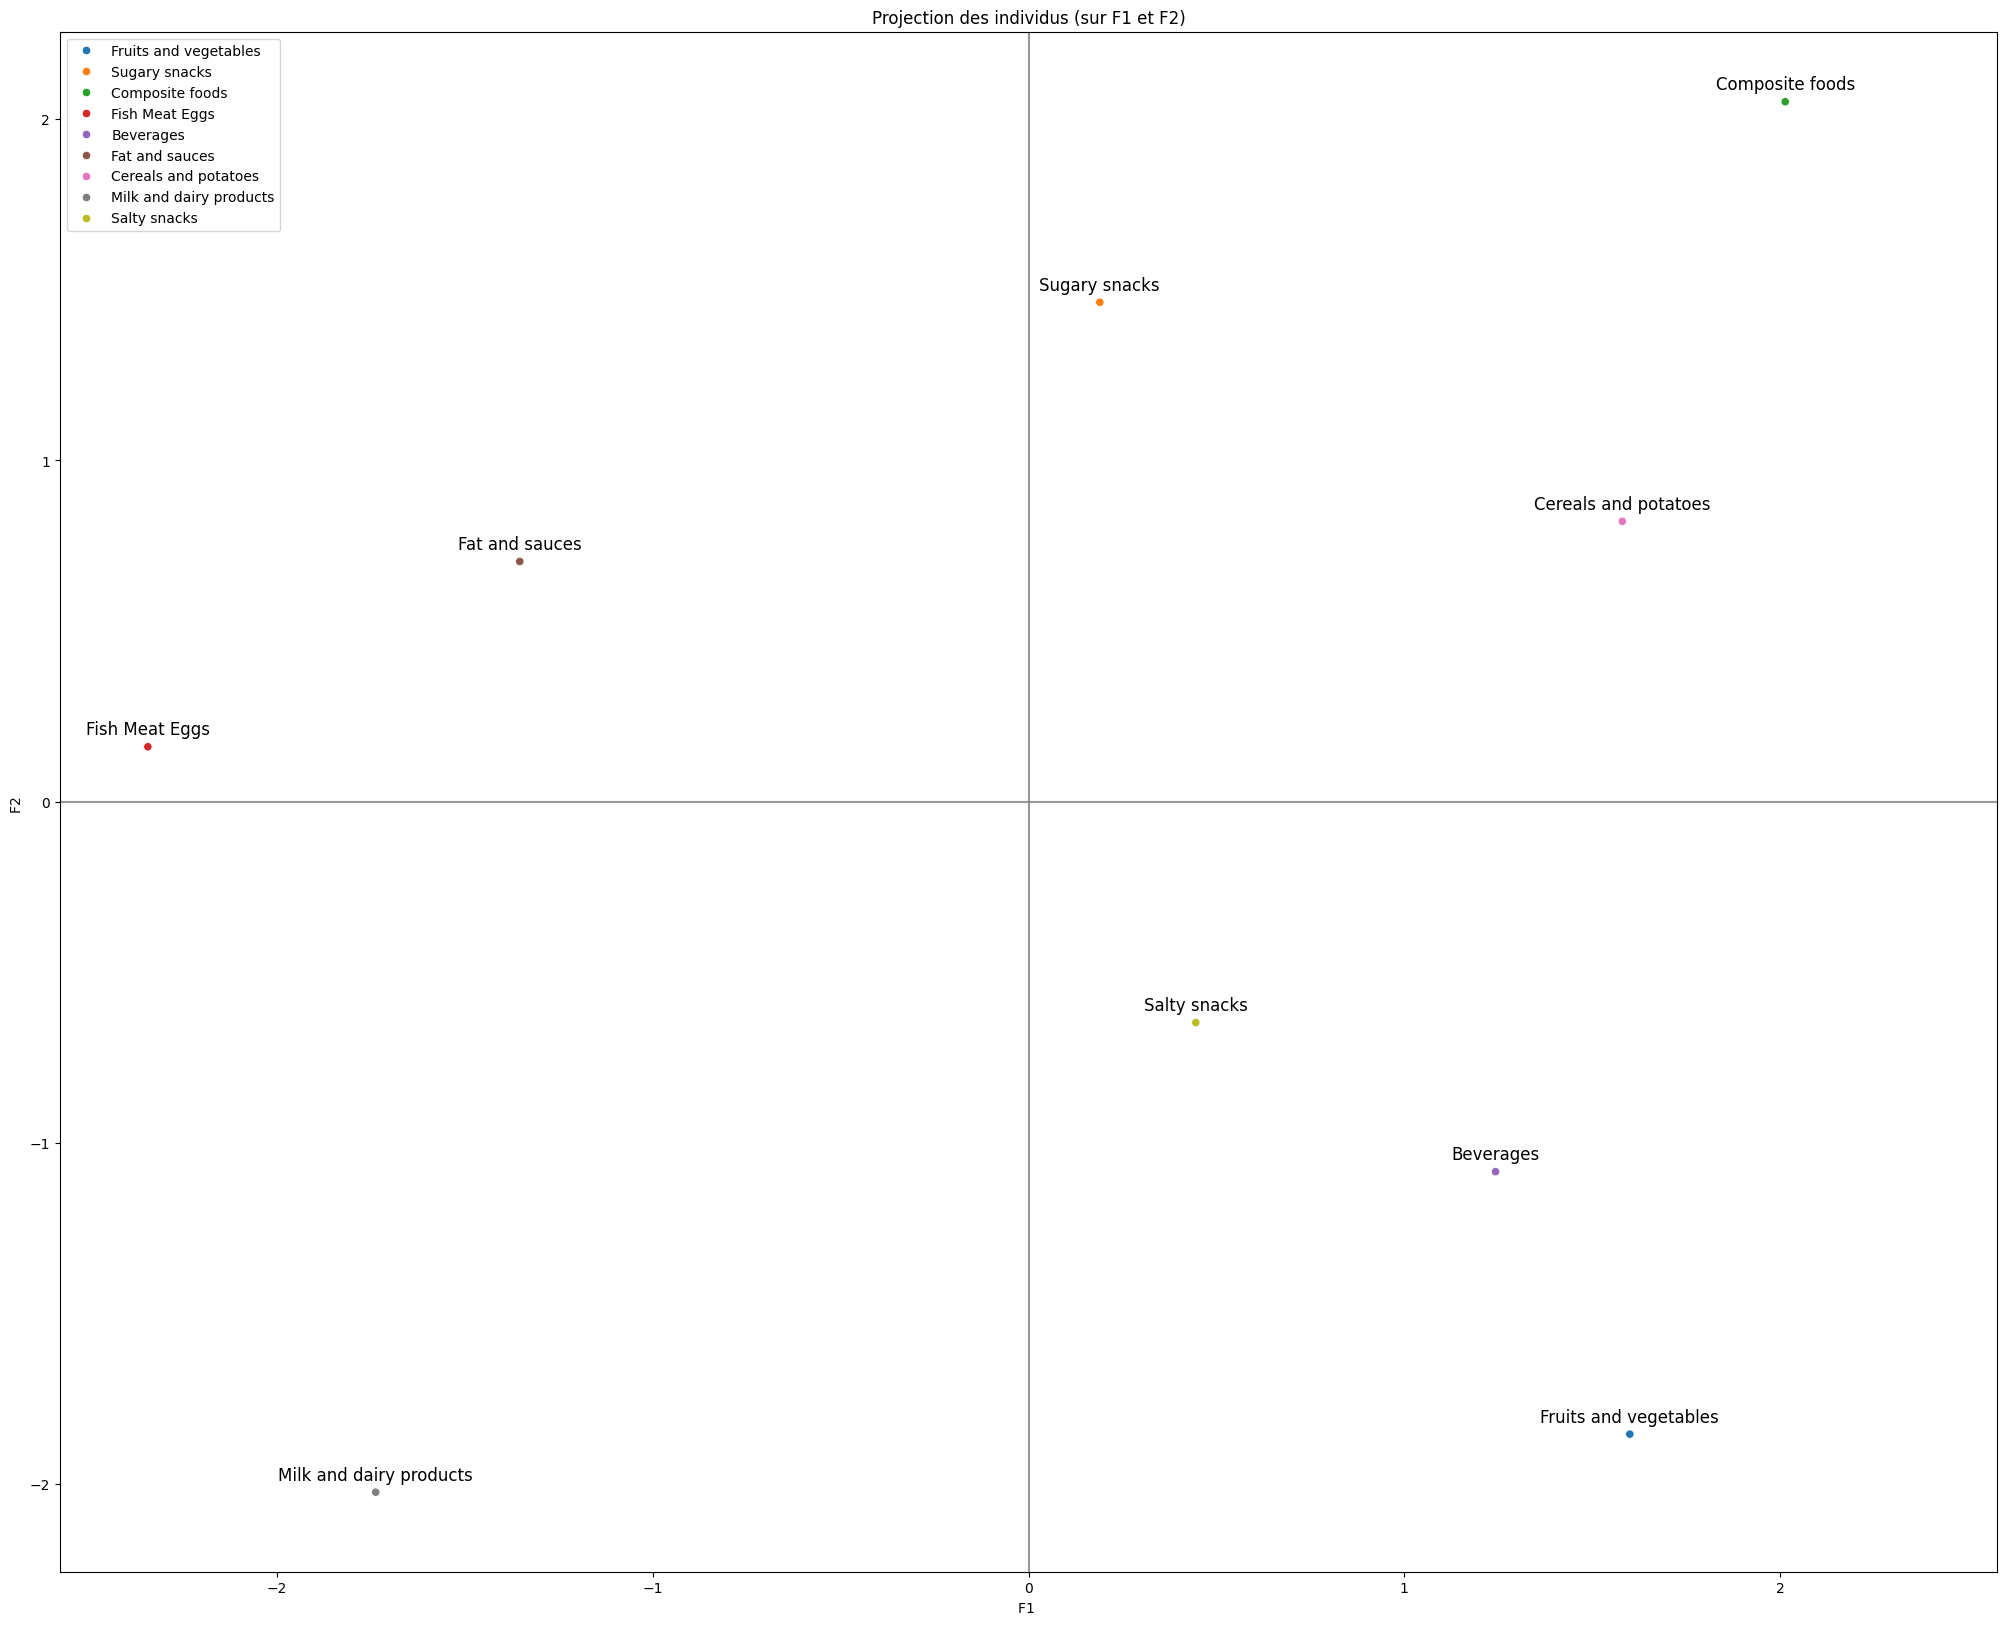

In [ ]:
x_y = [0,1]
unique_values = df[TARGET].unique()

# Appeler display_factorial_planes avec les coordonnées x et y
display_factorial_planes(cluster_centers, x_y, labels=unique_values, alpha=1, figsize=(25, 20), clusters=unique_values)

In [ ]:
# # x_y = [0,1]
# # display_factorial_planes(X_proj, x_y, figsize=(20, 16), clusters=df[TARGET])
# unique_values = df[TARGET].unique()
# print(unique_values)
# print(unique_values)

['Fruits and vegetables' 'Sugary snacks' 'Composite foods'
 'Fish Meat Eggs' 'Beverages' 'Fat and sauces' 'Cereals and potatoes'
 'Milk and dairy products' 'Salty snacks']
[[-0.01215365  0.8957744   0.69361708 -0.22396245 -0.23087261  0.02481993
  -0.08836988 -0.11656806]
 [-1.77695042 -1.99255986 -0.45459733 -0.85494874  0.06766962  0.36456235
   0.41714554  0.30284964]
 [-2.65398158  0.35306055 -0.12539992  0.26505721 -0.20012066 -0.02618278
  -0.01961653 -0.01371049]
 [ 1.64648339 -1.65137264  0.57408346  0.38567878 -0.30527104 -0.24042064
  -0.03577379 -0.01057579]
 [-0.05379143 -0.98502118  1.60796855  0.03392925  0.75904822  0.52806596
   0.01520648  0.04914973]
 [ 1.63971348  2.09049828 -0.1711923  -0.14017894  0.31411229 -0.19134148
   0.10034603  0.0918319 ]
 [-0.86857939  0.0273925  -0.91723525  0.06988555  0.15707522 -0.54887785
  -0.2315153  -0.08591619]
 [ 1.49153125 -1.1721757  -1.21648147 -0.56237453  0.19304893  0.05983042
  -0.11017252 -0.12756579]
 [ 1.64366215  0.821

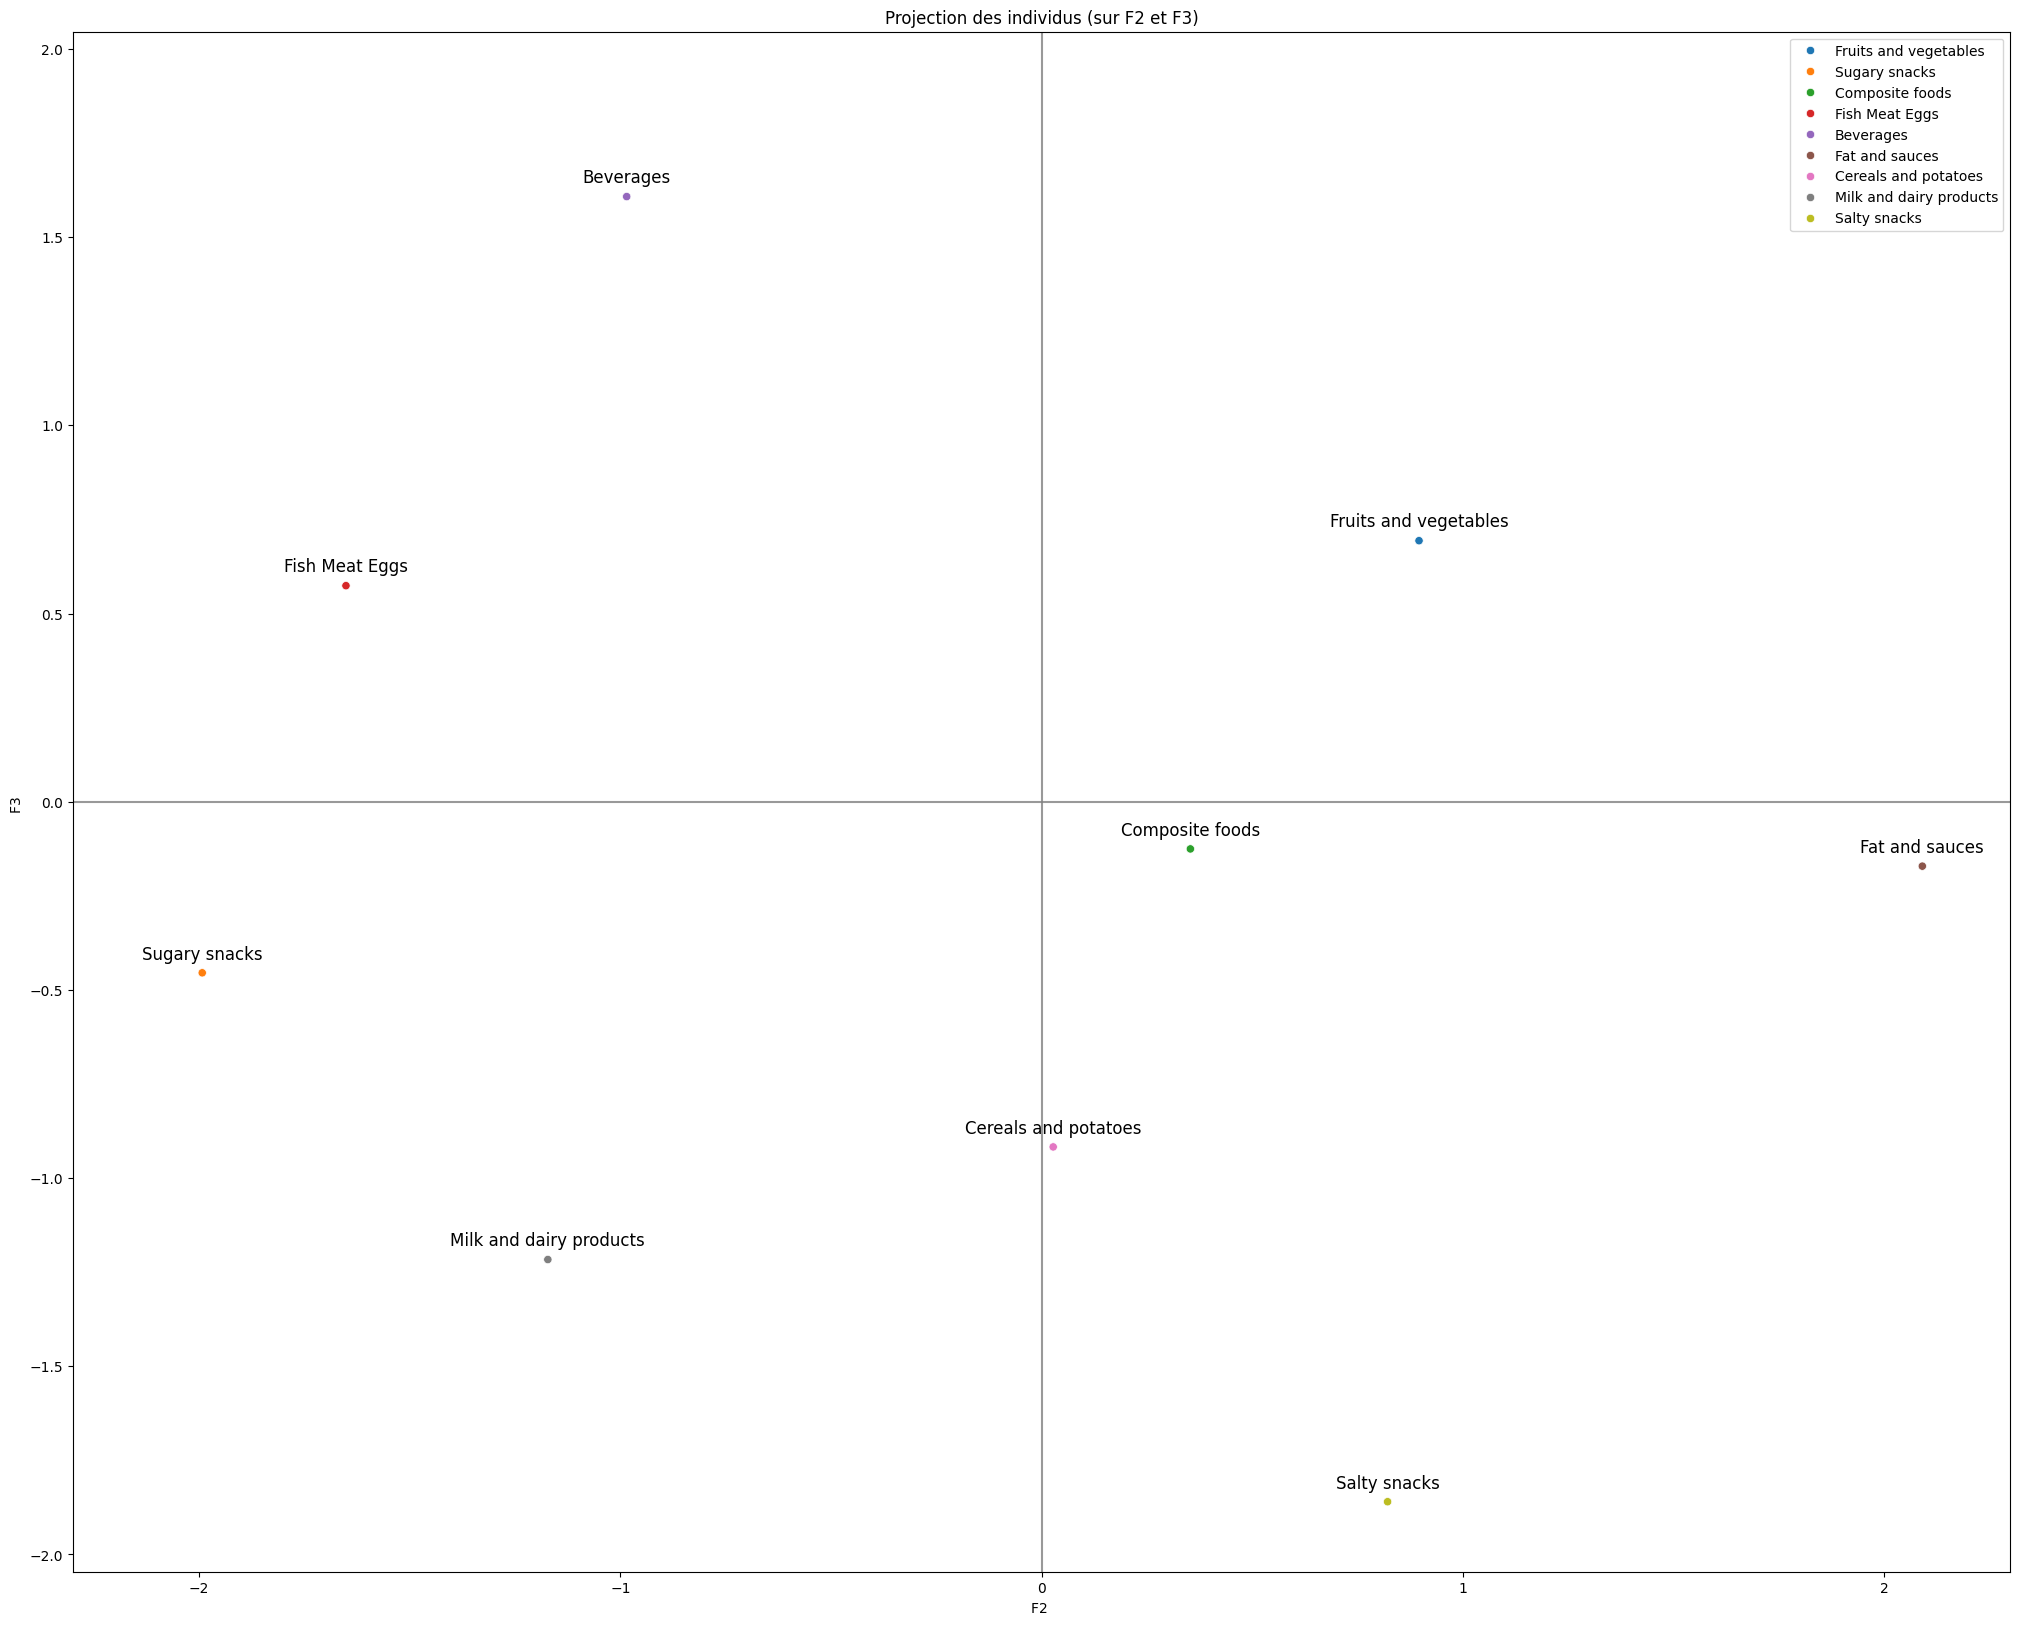

In [ ]:
x_y = [1,2]
unique_values = df[TARGET].unique()
print(unique_values)
print(cluster_centers)

# Appeler display_factorial_planes avec les coordonnées x et y
display_factorial_planes(cluster_centers, x_y, labels=unique_values, alpha=1, figsize=(25, 20), clusters=unique_values)


# **Conclusion**

## Pipeline

Test pour déterminer les NaN de energy_100g à partir des autres variables quantititatives

In [ ]:
# import pandas as pd
# import numpy as np
# from sklearn.linear_model import LinearRegression
# from sklearn.pipeline import Pipeline
# from sklearn.impute import KNNImputer, SimpleImputer
# from sklearn.utils.validation import check_is_fitted

# X = df[comp_feature_variable]
# y = df['energy_100g']

In [ ]:
# # Code Raphaël ici: comment récupére les indices où y est non nul
# y = np.array([np.NaN, 1, 100, 19, np.NaN])

# y_non_null_idx = np.argwhere(~np.isnan(y)).ravel()

# y_non_null = y[y_non_null_idx]
# y_non_null

In [ ]:
# from enum import Enum
# from sklearn.base import BaseEstimator, TransformerMixin

# class EnergyImputer(BaseEstimator, TransformerMixin):
#     def fit(self, X, y=None):
#         return self

#     def transform(self, X):
#         X['energy_100g'] = X.apply(lambda row: 4 * row['proteins_100g'] + 4 * row['carbohydrates_100g'] + 9 * row['fat_100g'] + 2 * row['fiber_100g'], axis=1)
#         return X

# # Importer les modules nécessaires
# from sklearn.pipeline import Pipeline
# from sklearn.impute import KNNImputer
# from sklearn.linear_model import LinearRegression

# # Définir les étapes de la pipeline, instantiation
# my_transformer = EnergyImputer()
# my_imputer = KNNImputer(n_neighbors=3)
# my_regressor = LinearRegression()

# # Créer la pipeline
# my_pipeline = Pipeline([
#     ('transformer', my_transformer),
#     ('imputer', my_imputer),
#     ('regressor', my_regressor)
# ])

# # Code Raphaël
# # OPTION 1: Option "Plus Facile": avec les pipelines
# # Etape 1: On va commencer par filtrer X et y là où y est non nul
# y_non_null_idx = np.argwhere(~np.isnan(y)).ravel()

# X_with_y_non_null = X[y_non_null_idx, :]
# y_non_null = y[y_non_null_idx]

# my_pipeline1 = Pipeline([
#     ('imputer', my_imputer),
#     ('regressor', my_regressor)
# ])

# my_pipeline2 = Pipeline([
#     ('transformer', my_transformer),
#     ('regressor', my_regressor)
# ])

# # Etape 2: on fit chaque pipeline avec si on veut un grid search et une cross validation
# # ...


# # OPTION 2: Option "Difficile" sans les pipelines
# # - Imputer : toutes les données
# # - Regressor: seulement les données avec y non NaN

# my_transformer = EnergyImputer()
# my_imputer = KNNImputer(n_neighbors=3)

# class METHOD_IMPUTATION(Enum):
#   ENERGY_IMPUTER = 'ENERGY_IMPUTER'
#   KNN = 'KNN'
#   TROISIEME_OPTION = 'NIMPORTE QUEL TEXTE'

# def fit_one_regressor(method_imputation):
#   # Le code ici fait l'hypothese que X et y sont des numpy array. a adapter
#   # dans le cas où ce sont des pandas ou series
#   # X = toutes les lignes
#   # y = toutes les lignes

#   # Etape 1: on impute X en utilisant toutes les données
#   if method_imputation == 'energy': # METHOD_IMPUTATION.ENERGY_IMPUTER:
#     X_transform = my_transformer.fit_transform(X)

#   elif method_imputation == 'imputer': # METHOD_IMPUTATION.KNN:
#     X_transform = my_imputer.fit_transform(X)

#   else:
#     raise NotImplementedError

#   # Etape 2: Maintenant on ne garde que X et y où y est non nul
#   y_non_null_idx = np.argwhere(~np.isnan(y)).ravel()
#   X_transform_for_regressor = X_transform[y_non_null_idx, :]
#   y_non_null = y[y_non_null_idx]

#   # On fit le modèle de prédiction là où y est non nul
#   my_regressor = LinearRegression()
#   my_regressor.fit(X_transform_for_regressor, y_non_null)
#   return my_regressor


# # Application:
# fit_one_regressor('energy')


In [ ]:
# # En même temps, on fit le KNNImputer ET la régression
# my_pipeline.fit(X, y) #entrainement

In [ ]:
# # On peut accéder aux élements individuels de la pipeline
# # Ici, les éléments qu'on récupère sont fittés
# my_fitted_transformer = my_pipeline.steps[0][1]
# my_fitted_imputer = my_pipeline.steps[1][1]
# my_fitted_regressor = my_pipeline.steps[2][1]

In [ ]:
# my_fitted_regressor.coef_

In [ ]:
# # Le code pour récupérer l'output de la première étape (entre KNNImputer et LinearRegression)
# # Quasiment tous les objets de sklearn ont 3 méthodes:
# # - fit
# # - fit_transform
# # - transform
# my_fitted_imputer.transform(X) #imputation des valeurs manquante

In [ ]:
# from sklearn.model_selection import GridSearchCV

# my_param_grid = {
#     'imputer__n_neighbors': [2, 3, 4],
#     'regressor__fit_intercept': [True, False]
# }

# from sklearn.metrics import mean_absolute_error


# gs = GridSearchCV(
#     estimator=my_pipeline,
#     param_grid=my_param_grid,
#     n_jobs=-1,
#     cv=3,
#     refit=True,  # Please refit again the best of all models on ALL Training data
#     # error_score=mean_absolute_error  # Check how to change the error_score
# )



In [ ]:
# gs.fit(X, y)

# # Visuzlize the Cross Validation results
# # 1 row by model
# # k columns for every k in the cross validation
# pd.DataFrame(gs.cv_results_)

# my_best_model = gs.best_estimator_

# y_pred = my_best_model.predict(X)

# import matplotlib.pyplot as plt

# plt.scatter(y, y_pred)

#brouillons

In [ ]:
# '''
#     Parameters :
#     series (pandas.serie): A serie of numerical value

#     Return :
#     series (pandas.serie): A filtered serie which contains only outliers
# '''

# def mark_outliers(df, column):
#     Q1 = df[column].quantile(0.25)
#     Q3 = df[column].quantile(0.75)
#     IQR = Q3 - Q1
#     mask = (df[column] < Q1 - 1.5 * IQR) | (df[column] > Q3 + 1.5 * IQR)
#     return mask

# for var in num_feature_variable:
#     df[f'{var}_is_outlier'] = mark_outliers(df, var)

In [ ]:
# # number of outliers per variable
# print('outliers by variable : \n---')
# tot_outlier = 0
# for var in num_feature_variable:
#     count_outlier = df.loc[df[f'{var}_is_outlier'], var].count()
#     tot_outlier += count_outlier
#     print(f'{var} : {count_outlier}')
# print(f'\ntotal : {tot_outlier}')

In [ ]:
# # fit and predict by using grid search

# from  sklearn.neighbors import KNeighborsClassifier
# # instantiation de l'objet model
# model = KNeighborsClassifier()

# from sklearn.model_selection import train_test_split
# #Separation des données d'entrainement
# X = df[comp_feature_variable]
# y = df['pnns_groups_2']
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)

# # entrainement du modèle de données
# model.fit(X_train, y_train)

# # evaluation du modèle
# print(model.score(X_train, y_train))

In [ ]:
# #Regarder la qualité des prédictions

# from sklearn.metrics import accuracy_score
# # utiliser le modèle pour prédire les valeurs
# y_pred = model.predict(X_test)

# # Calculer la précision
# accuracy = accuracy_score(y_test, y_pred)
# print(f'Accuracy: {accuracy}')

# from sklearn.metrics import classification_report
# # Afficher le rapport de classification
# print(classification_report(y_test, y_pred))

# from sklearn.metrics import confusion_matrix
# # Calculer la matrice de confusion
# conf_matrix = confusion_matrix(y_test, y_pred)
# print(conf_matrix)

## training withou pipelin

In [ ]:
# # normalize values
# transformer = PowerTransformer() #model which normalize values
# df_int_transformed = transformer.fit_transform(df[NUMERIC_FEATURES]) #array
# df_int_transformed = pd.DataFrame(df_int_transformed, columns=NUMERIC_FEATURES)
# df_transformed = pd.concat([df_int_transformed, df[[PRODUCT_NAME, TARGET]]], axis=1)
# df_transformed

# # check transformation values
# df_transformed[NUMERIC_FEATURES].describe().apply(lambda s: s.apply('{0:.2f}'.format))

# # check transformation distribution
# df_transformed[NUMERIC_FEATURES].hist(bins=50)
# plt.tight_layout()

# # transform the class form text to integer
# encoder =  LabelEncoder()
# y_encoded = encoder.fit_transform(df_transformed[TARGET].values)

# # create dataset for training and testing
# X = df_transformed[NUMERIC_FEATURES].values
# X_train, X_test, y_train_encoded, y_test_encoded = train_test_split(X, y_encoded, test_size=0.20, random_state=42)